## Behavioral Cloning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm_notebook
from keras.preprocessing import image as kimage
from keras.models import model_from_json
from model import preprocess, calculate_steering, calculate_data_len, generate_data, FLAGS
%matplotlib inline

Using TensorFlow backend.


In [2]:
data_dir = 'data_sdc'
driving_log = pd.read_csv(data_dir + '/driving_log.csv', usecols=[0, 1, 2, 3])

In [3]:
driving_log.head()

,center,left,right,steering
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0


In [4]:
driving_log.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
steering,8036.0,0.00407,0.12884,-0.942695,0.0,0.0,0.0,1.0


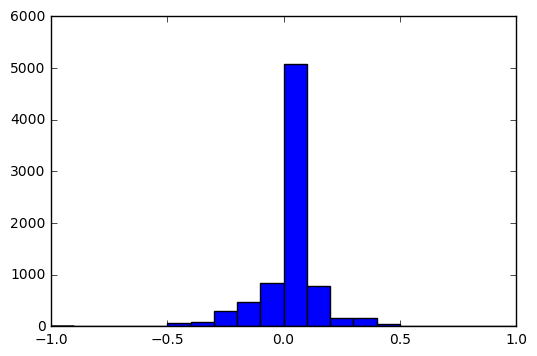

In [8]:
plt.hist(driving_log['steering'], bins=np.arange(-1, 1 + 0.1, 0.1));

Data len:  33573



Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/vfcosta/anaconda3/envs/tensorflow/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vfcosta/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vfcosta/anaconda3/envs/tensorflow/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




All steering angles len:  33573


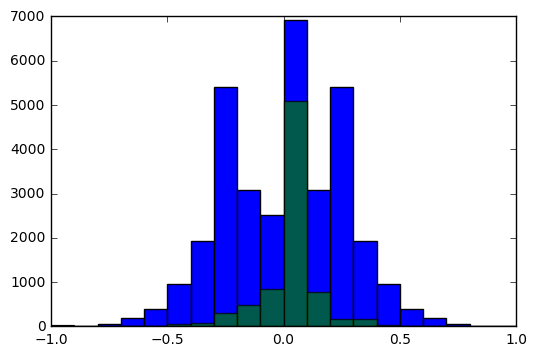

In [9]:
image_labels = ['center', 'right', 'left']
data_len = calculate_data_len(driving_log, positions=len(image_labels))
print("Data len: ", data_len)

all_steering_angles = np.array([])
for images, steering_angles in tqdm_notebook(generate_data(driving_log), total=int(data_len/FLAGS.batch_size)):
    all_steering_angles = np.hstack((all_steering_angles, steering_angles))
    if(len(all_steering_angles)>=data_len):
        break

print("All steering angles len: ", len(all_steering_angles))

plt.hist(all_steering_angles, bins=np.arange(-1, 1 + 0.1, 0.1));
plt.hist(driving_log['steering'], alpha=0.7, bins=np.arange(-1, 1 + 0.1, 0.1));

(18, 80, 3)


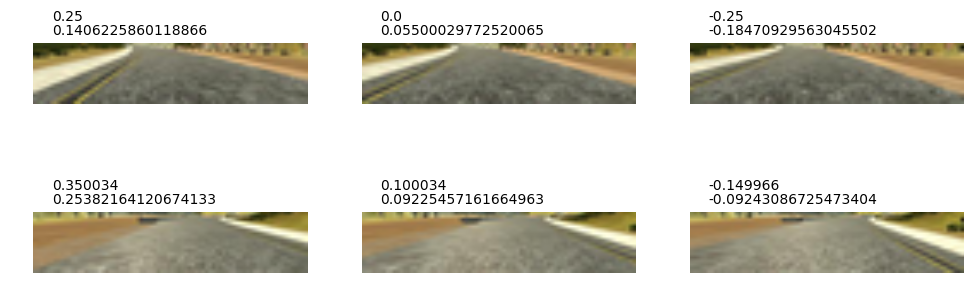

In [7]:
# Load model
with open("model.json", 'r') as jfile:
    model = model_from_json(jfile.read())
model.compile("adam", "mse")
model.load_weights("model.h5")

# Plot sample images
n_samples = 2
indexes = np.random.randint(0, len(driving_log), n_samples)
fig, axs = plt.subplots(n_samples, 3)
fig.set_size_inches(12, 4)

for i,index in enumerate(indexes):
    for j,label in enumerate(['left', 'center', 'right']):
        axs[i,j].axis('off')
        steering = driving_log.ix[index]['steering']
        axs[i,j].text(5,-7, calculate_steering(steering, label))
        image = kimage.load_img(data_dir + "/" + driving_log.ix[index][label].strip())
        image_array = preprocess(image, normalize=False)
        if i==0 and j==0: print(image_array.shape)

        processed_image = preprocess(image)
        predicted_steering = float(model.predict(processed_image[None, :, :, :], batch_size=1))
        axs[i,j].text(5, -3, predicted_steering)
        axs[i,j].imshow(image_array)